In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask

import shapely
import geopandas as gpd
import salem

import cartopy as cart
import cartopy.crs as ccrs

import ecco_v4_py as ecco

import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r4_output/').rename({'face': 'tile'})
budg = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r4_budgets/').rename({'face': 'tile'})

In [4]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC).transpose('k','tile','j','i')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


In [5]:
# Volume fluxes (m^3/s)
budg_vol = budg*vol

/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing numbe

### Subselect time period

### Define the section lines 

In [6]:
ptDaS1,ptDaS2 = ecco.get_section_endpoints('Davis Strait')
ptDeS1,ptDeS2 = ecco.get_section_endpoints('Denmark Strait')
ptIF1,ptIF2 = ecco.get_section_endpoints('Iceland Faroe')
ptFS1,ptFS2 = ecco.get_section_endpoints('Faroe Scotland')
ptSN1,ptSN2 = ecco.get_section_endpoints('Scotland Norway')
ptFrS1,ptFrS2 = ecco.get_section_endpoints('Fram Strait')
ptSvN1,ptSvN2 = ecco.get_section_endpoints('Barents Sea')
ptLG1,ptLG2 = ecco.get_section_endpoints('Labrador Greenland')
ptHS1,ptHS2 = ecco.get_section_endpoints('Hudson Strait')
ptEC1,ptEC2 = ecco.get_section_endpoints('English Channel')
ptSB1,ptSB2 = ecco.get_section_endpoints('Newfoundland Iberia')
ptBS1,ptBS2 = ecco.get_section_endpoints('Bering Strait')

maskC_DaS, maskW_DaS, maskS_DaS = ecco.get_section_line_masks(ptDaS1,ptDaS2,main)
maskC_DeS, maskW_DeS, maskS_DeS = ecco.get_section_line_masks(ptDeS1,ptDeS2,main)
maskC_IF, maskW_IF, maskS_IF = ecco.get_section_line_masks(ptIF1,ptIF2,main)
maskC_FS, maskW_FS, maskS_FS = ecco.get_section_line_masks(ptFS1,ptFS2,main)
maskC_SN, maskW_SN, maskS_SN = ecco.get_section_line_masks(ptSN1,ptSN2,main)
maskC_FrS, maskW_FrS, maskS_FrS = ecco.get_section_line_masks(ptFrS1,ptFrS2,main)
maskC_SvN, maskW_SvN, maskS_SvN = ecco.get_section_line_masks(ptSvN1,ptSvN2,main)
maskC_LG, maskW_LG, maskS_LG = ecco.get_section_line_masks(ptLG1,ptLG2,main)
maskC_HS, maskW_HS, maskS_HS = ecco.get_section_line_masks(ptHS1,ptHS2,main)
maskC_EC, maskW_EC, maskS_EC = ecco.get_section_line_masks(ptEC1,ptEC2,main)
maskC_SB, maskW_SB, maskS_SB = ecco.get_section_line_masks(ptSB1,ptSB2,main)
maskC_BS, maskW_BS, maskS_BS = ecco.get_section_line_masks(ptBS1,ptBS2,main)

### Reference salinity

In [7]:
maskC_spna = (maskC_DaS + maskC_DeS + maskC_IF + maskC_FS  + maskC_HS + maskC_SB + maskC_EC)\
            .where(maskC_DaS + maskC_DeS + maskC_IF + maskC_FS + maskC_HS + maskC_SB + maskC_EC==1,0)

In [8]:
maskC_nsea = (maskC_DeS + maskC_IF + maskC_FS + maskC_SN + maskC_FrS + maskC_SvN)\
            .where(maskC_DeS + maskC_IF + maskC_FS + maskC_SN + maskC_FrS + maskC_SvN==1,0)

In [9]:
SALT_nsea_bnd = (main.SALT*maskC_nsea.where((maskC_nsea==1)&(main.hFacC[0].values==1))).mean('time')
vol_nsea_bnd = vol*maskC_nsea.where((maskC_nsea==1)&(main.hFacC[0].values==1))

Sref_nsea = (SALT_nsea_bnd*vol_nsea_bnd).sum(dim=['tile','k','j','i']).values/\
            vol_nsea_bnd.sum(dim=['tile','k','j','i']).values
print(Sref_nsea)

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


34.936491560020585


In [10]:
sal_IF = ((main.SALT*maskC_IF).where((maskC_IF==1)&(main.hFacC[0].values==1))*vol).sum(dim=['tile','j'])
vol_IF = (vol*maskC_IF).where((maskC_IF==1)&(main.hFacC[0].values==1)).sum(dim=['tile','j'])

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


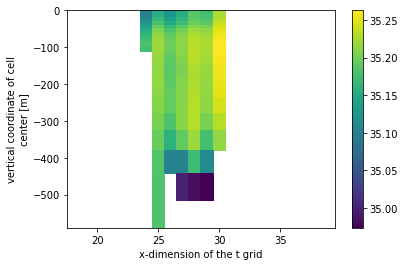

In [11]:
(sal_IF/vol_IF).mean('time')[:24,18:40].swap_dims({'k':'Z'}).plot()

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


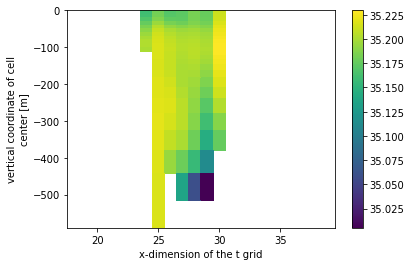

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


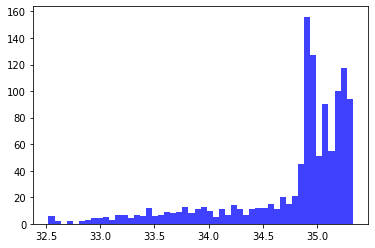

In [12]:
# the histogram of the data
x = SALT_nsea_bnd.values.flatten()[~np.isnan(SALT_nsea_bnd.values.flatten())]
n, bins, patches = plt.hist(x[np.nonzero(x)], 50, facecolor='b', alpha=0.75)
plt.show()

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


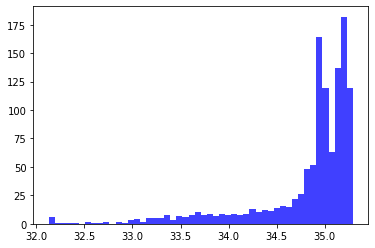

In [13]:
SALT_spna_bnd = (main.SALT*maskC_spna.where((maskC_spna==1)&(main.hFacC[0].values==1))).mean('time')
vol_spna_bnd = vol*maskC_spna.where((maskC_spna==1)&(main.hFacC[0].values==1))

Sref_spna = (SALT_spna_bnd*vol_spna_bnd).sum(dim=['tile','k','j','i']).values/\
            vol_spna_bnd.sum(dim=['tile','k','j','i']).values
print(Sref_spna)

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


35.035707582075


/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


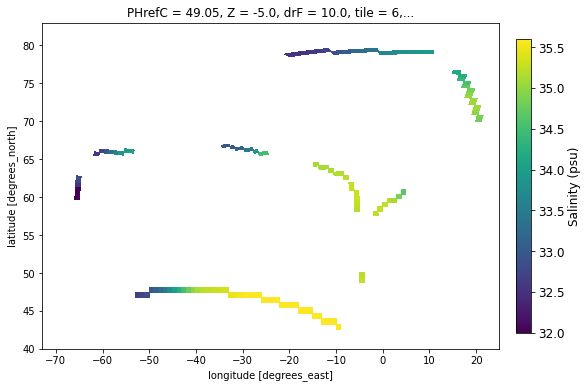

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

p=SALT_nsea_bnd[0,2].plot(ax=ax, x='XC', y='YC', add_colorbar=False, vmin=32, vmax=35.6)
SALT_spna_bnd[0,10].plot(ax=ax, x='XC', y='YC', add_colorbar=False, vmin=32, vmax=35.6)
SALT_spna_bnd[0,2].plot(ax=ax, x='XC', y='YC', add_colorbar=False, vmin=32, vmax=35.6)

SALT_nsea_bnd[0,6,:73,:30].plot(ax=ax, x='XC', y='YC', add_colorbar=False, vmin=32, vmax=35.6)
SALT_nsea_bnd[0,6,60:,10:70].plot(ax=ax, x='XC', y='YC', add_colorbar=False, vmin=32, vmax=35.6)
ax.set_xlim([-73,25])
ax.set_ylim([40,83])
ax.set_xticks(np.arange(-70,30,10))
ax.set_yticks(np.arange(40,85,5))

cbar = fig.colorbar(p, ax=ax, ticks=np.arange(32,36,0.5),shrink=0.9, pad = 0.03)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Salinity (psu)', fontsize=12)

plt.show()

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


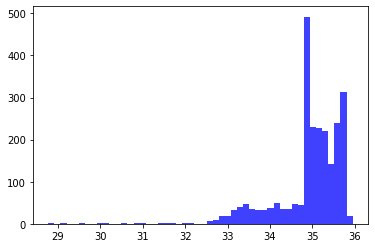

In [15]:
# the histogram of the data
x = SALT_spna_bnd.values.flatten()[~np.isnan(SALT_spna_bnd.values.flatten())]
n, bins, patches = plt.hist(x[np.nonzero(x)], 50, facecolor='b', alpha=0.75)
plt.show()

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


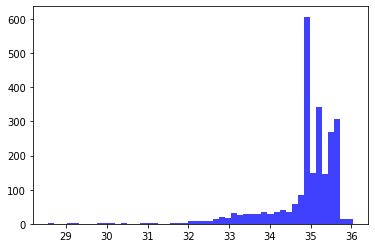

In [16]:
# Reference salinity
Sref = 35.0
#Sref = 35.1

In [17]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Watts to Petawatts
pw = 1e-15

# m^3 to Sverdrup
Sv = 10**-6

In [18]:
# Remove oceFWflx from WVELMASS
WVELMASS = main.WVELMASS.transpose('time','tile','k_l','j','i')
oceFWflx = main.oceFWflx.assign_coords(k_l=0).expand_dims('k_l').transpose('time','tile','k_l','j','i')

oceFWflx = (oceFWflx/rhoconst)
WVELMASS = xr.concat([WVELMASS.sel(k_l=0) + oceFWflx, WVELMASS[:,:,1:]], 
                     dim='k_l').transpose('time','tile','k_l','j','i')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  import sys


In [19]:
grid = ecco.get_llc_grid(main)

In [20]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')
SALT_at_w = grid.interp(main.SALT, 'Z', boundary='extend')

In [21]:
# Freshwater advective (Eulerian+Bolus) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS+main.UVELSTAR)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS+main.VVELSTAR)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref
#ADVr_FW = WVELMASS*main.rA*(Sref-SALT_at_w)/Sref
ADVr_FW = (WVELMASS+main.WVELSTAR)*main.rA*(Sref-SALT_at_w)/Sref

In [22]:
# Volumetric transport
x_vol = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
y_vol = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

### Calculate section transports

In [23]:
sections = ['Davis Strait', 'Denmark Strait', 'Iceland Faroe', 'Faroe Scotland', 'Scotland Norway',
           'Fram Strait','Barents Sea','Labrador Greenland', 'Hudson Strait','English Channel','Newfoundland Iberia',
           'Bering Strait']

vol_trsp = []
fw_trsp = []

for name in sections:
    print(name)
    pt1,pt2 = ecco.get_section_endpoints(name)
    maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)
    
    # Volume transports
    sec_trsp_x = (x_vol * maskW).sum(dim=['i_g','j','tile'])
    sec_trsp_y = (y_vol * maskS).sum(dim=['i','j_g','tile'])
    sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()
    vol_trsp.append(sec_trsp*Sv)

    # Freshwater transports
    sec_trsp_x = (ADVx_FW * maskW).sum(dim=['i_g','j','tile'])
    sec_trsp_y = (ADVy_FW * maskS).sum(dim=['i','j_g','tile'])
    sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()
    fw_trsp.append(sec_trsp*Sv)

Davis Strait
Denmark Strait
Iceland Faroe
Faroe Scotland
Scotland Norway
Fram Strait
Barents Sea
Labrador Greenland
Hudson Strait
English Channel
Newfoundland Iberia
Bering Strait


In [24]:
vol_trsp = xr.concat(vol_trsp,pd.Index(sections, name='section'))
fw_trsp = xr.concat(fw_trsp,pd.Index(sections, name='section'))

In [25]:
ds = vol_trsp.to_dataset(name='vol')
ds['fw'] = fw_trsp

In [26]:
ds.to_netcdf('/mnt/efs/data/ecco/eccov4r4_section_transports_fw.nc', format='NETCDF4')

In [27]:
ds.sel(time=slice('1992-01-01','2017-12-31')).mean('time').to_dataframe()

,vol,fw
section,,
Davis Strait,-1.446494,-0.074189
Denmark Strait,-4.988168,-0.071405
Iceland Faroe,3.180308,-0.019586
Faroe Scotland,1.982507,-0.027006
Scotland Norway,0.093872,0.008687
Fram Strait,-2.544709,-0.058501
Barents Sea,2.885422,-0.010283
Labrador Greenland,-1.502708,-0.128913
Hudson Strait,-0.028737,-0.026805


,vol,fw
section,,
Davis Strait,-1.551961,-0.099460
Denmark Strait,-5.441123,-0.080708
Iceland Faroe,3.590563,-0.010294
Faroe Scotland,2.159763,-0.021735
Scotland Norway,0.070494,0.008502
Fram Strait,-2.888645,-0.067076
Barents Sea,3.328499,-0.000686
Labrador Greenland,-1.609011,-0.156405
Hudson Strait,-0.029883,-0.028548


In [28]:
vol_trsp = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_section_transports_fw.nc').vol
fw_trsp = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_section_transports_fw.nc').fw

In [29]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [30]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [31]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

In [32]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('tile','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

### Volume Budget

In [33]:
volume = []
for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Total volume (m^3)
    V = (vol*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    volume.append(V)

In [34]:
terms = ['tendV', 'forcV', 'ConvV','totalV']

In [35]:
budg_volume = []
for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Volume tendency (m^3/s)
    tendV = (budg_vol.tendV*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sea surface forcing on volume (m^3/s)
    forcV = (budg_vol.forcV*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Convergence of volume transport (m^3/s)
    ConvV = ((budg_vol.hConvV+budg_vol.vConvV)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sum of terms (m^3/s)
    totalV = ConvV + forcV
    
    results = dask.compute(tendV.reset_coords(drop=True)*Sv, forcV.reset_coords(drop=True)*Sv,
                           ConvV.reset_coords(drop=True)*Sv, totalV.reset_coords(drop=True)*Sv)
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_volume.append(budg)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [36]:
region = ['spna', 'nsea', 'lsea']
budg_volume = xr.concat(budg_volume,pd.Index(region, name='region'))
volume = xr.concat(volume,pd.Index(region, name='region'))

#### Save to netcdf

In [37]:
ds = budg_volume.reset_coords(drop=True).to_dataset(name='budg_vol')

In [39]:
ds

<xarray.Dataset>
Dimensions:   (region: 3, term: 4, time: 312)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 ... 2017-12-14T12:00:00
  * term      (term) object 'tendV' 'forcV' 'ConvV' 'totalV'
  * region    (region) object 'spna' 'nsea' 'lsea'
Data variables:
    budg_vol  (region, term, time) float64 0.0 0.2952 ... -0.04107 -0.08475

In [ ]:
ds.to_netcdf('/mnt/efs/data/ecco/eccov4r4_budg_vol.nc', format='NETCDF4')

In [40]:
from datetime import date

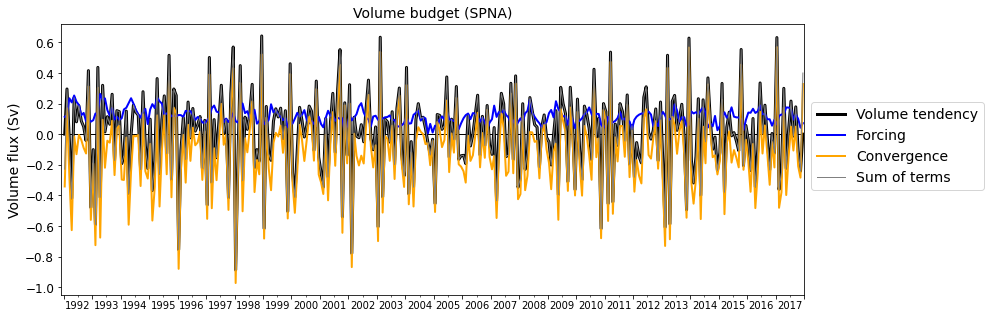

In [44]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set_title(r'Volume budget (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='tendV'), lw=3, color='black',label='Volume tendency')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='forcV'), lw=2, color='blue',label='Forcing')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='ConvV'), lw=2, color='orange',label='Convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='totalV'), lw=1, color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

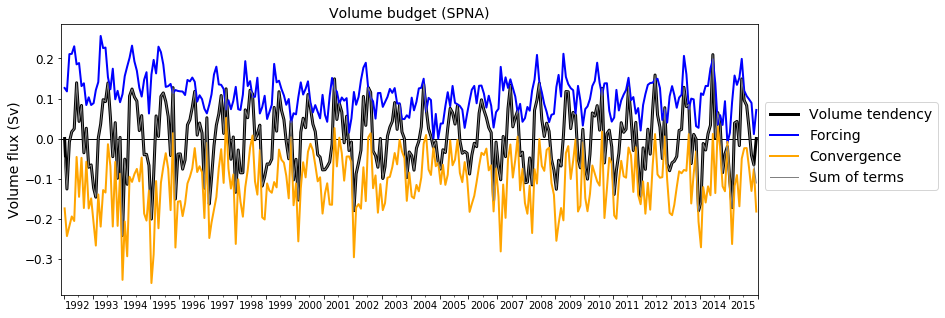

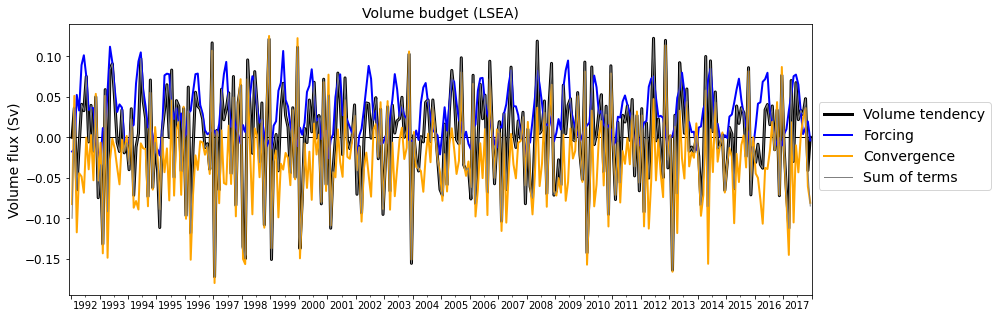

In [43]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set_title(r'Volume budget (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='tendV'), lw=3, color='black',label='Volume tendency')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='forcV'), lw=2, color='blue',label='Forcing')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='ConvV'), lw=2, color='orange',label='Convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='totalV'), lw=1, color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

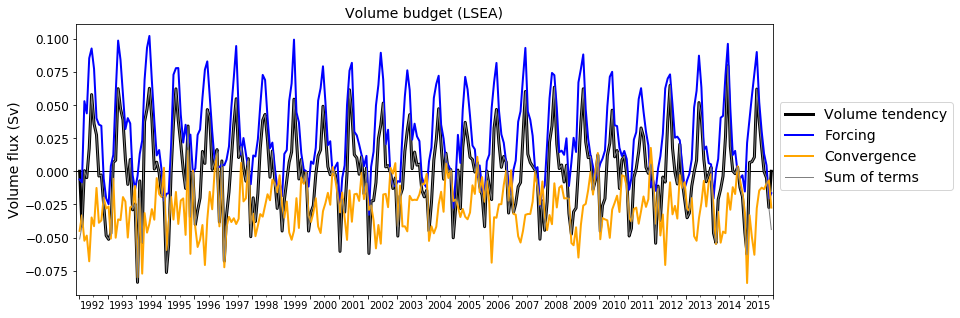

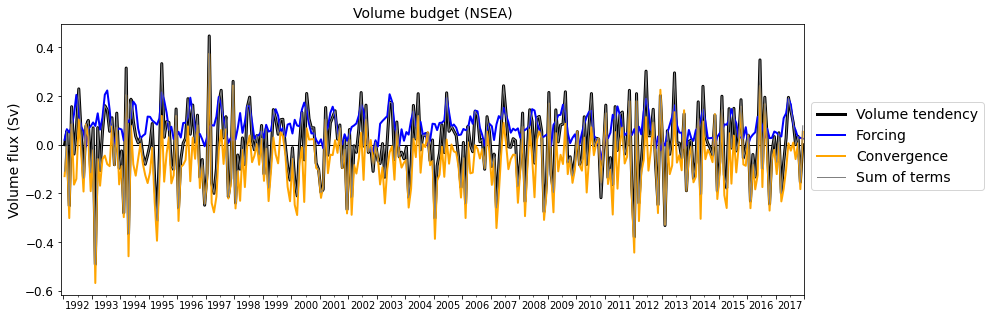

In [45]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set_title(r'Volume budget (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='nsea',term='tendV'), lw=3, color='black',label='Volume tendency')
ax.plot(budg_volume.time, budg_volume.sel(region='nsea',term='forcV'), lw=2, color='blue',label='Forcing')
ax.plot(budg_volume.time, budg_volume.sel(region='nsea',term='ConvV'), lw=2, color='orange',label='Convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='nsea',term='totalV'), lw=1, color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

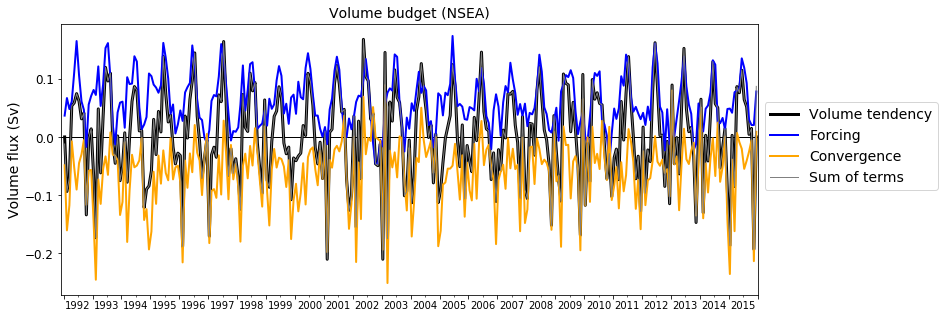

In [46]:
ConvV_spna_bnd = vol_trsp.sel(section='Newfoundland Iberia') + vol_trsp.sel(section='English Channel') \
                    - vol_trsp.sel(section='Hudson Strait') - vol_trsp.sel(section='Davis Strait') \
                    - vol_trsp.sel(section='Denmark Strait') - vol_trsp.sel(section='Iceland Faroe') \
                    - vol_trsp.sel(section='Faroe Scotland')

In [47]:
ConvV_nsea_bnd = vol_trsp.sel(section='Denmark Strait') + vol_trsp.sel(section='Iceland Faroe') \
                    + vol_trsp.sel(section='Faroe Scotland') + vol_trsp.sel(section='Scotland Norway') \
                    - vol_trsp.sel(section='Fram Strait') - vol_trsp.sel(section='Barents Sea')

In [48]:
ConvV_lsea_bnd = vol_trsp.sel(section='Labrador Greenland') - vol_trsp.sel(section='Hudson Strait') \
                    - vol_trsp.sel(section='Davis Strait')

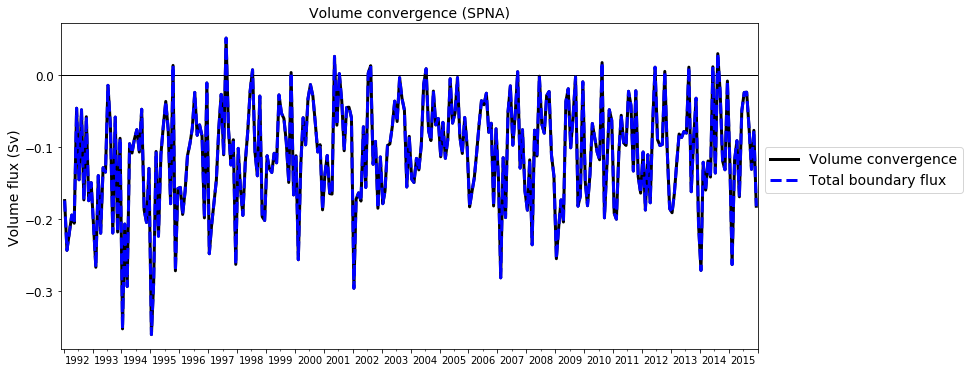

### Freshwater budget

In [50]:
def conv3d(ADVx, ADVy, ADVr):
    
    ADVxy_diff = grid.diff_2d_vector({'X' : ADVx, 'Y' : ADVy}, boundary = 'fill')
    adv_hConv = -(ADVxy_diff['X'] + ADVxy_diff['Y'])
    adv_vConv = grid.diff(ADVr, 'Z', boundary='fill')
    
    return adv_hConv+adv_vConv

In [51]:
# Liquid freshwater content (m^3)
lfwc = ((Sref - main.SALT)/Sref)*vol

In [52]:
# Freshwater tendency (m^3/s)
tendFw = grid.diff((Sref-main.SALT_snp)/Sref, 'T', boundary='fill', fill_value=0.0)*vol/main.dt

# Freshwater forcing (m^3/s)
forcFw = main.oceFWflx/rhoconst*main.rA

# Convergence of freshwater advection (m^3/s)
adv_ConvFw = conv3d(ADVx_FW,ADVy_FW,ADVr_FW)

/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,


In [53]:
terms = ['tendFw', 'forcFw', 'adv_ConvFw','ConvFw', 'totalFw', 'lfwc']

budg_fw = []

for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Liquid freshwater content (m^3)
    lfwc_mask = (lfwc*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Freshwater tendency (m^3/s)
    tendFw_mask = (tendFw*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Freshwater forcing (m^3/s)
    forcFw_mask = (forcFw*mask.where(mask==1)).sum(dim=['tile','j','i'])
    
    # Convergence of freshwater advection (m^3/s)
    adv_ConvFw_mask = (adv_ConvFw*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Total convergence (m^3/s)
    ConvFw_mask = adv_ConvFw_mask# + dif_ConvFw_spna
    
    # Sum of terms (m^3/s)
    totalFw_mask = ConvFw_mask + forcFw_mask
    
    results = dask.compute(tendFw_mask.reset_coords(drop=True)*Sv, forcFw_mask.reset_coords(drop=True)*Sv, 
                           adv_ConvFw_mask.reset_coords(drop=True)*Sv,ConvFw_mask.reset_coords(drop=True)*Sv,
                           totalFw_mask.reset_coords(drop=True)*Sv, lfwc_mask.reset_coords(drop=True)*Sv)
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_fw.append(budg)

In [54]:
region = ['spna', 'nsea', 'lsea']
budg_fw = xr.concat(budg_fw,pd.Index(region, name='region'))

In [55]:
budg_fw

<xarray.DataArray (region: 3, term: 6, time: 312)>
array([[[ 0.00000000e+00,  2.00290550e-01,  3.15926793e-01, ...,
         -1.12894085e-02, -6.34132125e-02,  0.00000000e+00],
        [ 1.12807478e-01,  1.25043108e-01,  2.34424435e-01, ...,
          9.97398638e-02,  4.21101270e-02,  7.19628655e-02],
        [ 8.78509621e-02,  1.21927260e-01,  1.54731013e-01, ...,
         -7.87734571e-02, -7.74592450e-02, -1.02883286e-01],
        [ 8.78509621e-02,  1.21927260e-01,  1.54731013e-01, ...,
         -7.87734571e-02, -7.74592450e-02, -1.02883286e-01],
        [ 2.00658440e-01,  2.46970369e-01,  3.89155448e-01, ...,
          2.09664066e-02, -3.53491180e-02, -3.09204205e-02],
        [ 5.82187451e+06,  6.23672971e+06,  6.83674159e+06, ...,
          5.89884689e+06,  5.83608108e+06,  5.59569807e+06]],

       [[ 0.00000000e+00, -3.81343485e-02, -2.27739669e-02, ...,
         -3.99296597e-02, -3.31292581e-02,  0.00000000e+00],
        [ 2.01626884e-02,  6.35839069e-02,  5.00333899e-02, ...,
          2.81619163e-02,  2.82919205e-02,  2.46767055e-02],
        [-2.32827024e-02, -7.34815123e-02, -5.31008439e-02, ...,
         -3.76336390e-02, -3.06806935e-02,  5.35610717e-03],
        [-2.32827024e-02, -7.34815123e-02, -5.31008439e-02, ...,
         -3.76336390e-02, -3.06806935e-02,  5.35610717e-03],
        [-3.12001397e-03, -9.89760540e-03, -3.06745407e-03, ...,
         -9.47172272e-03, -2.38877302e-03,  3.00328127e-02],
        [ 1.05198212e+07,  1.04607620e+07,  1.03959444e+07, ...,
          8.78030071e+06,  8.67439978e+06,  8.62790084e+06]],

       [[ 0.00000000e+00, -1.82564038e-02,  2.50235618e-02, ...,
          2.23959404e-02,  1.97822261e-02,  0.00000000e+00],
        [-1.75307591e-02, -1.48061574e-02,  5.22921690e-02, ...,
          1.15604405e-02,  1.95143149e-02, -3.96430441e-03],
        [-8.38185534e-03,  3.47804848e-04, -2.32633242e-02, ...,
          1.04769788e-02,  4.20803464e-04, -2.90068601e-02],
        [-8.38185534e-03,  3.47804848e-04, -2.32633242e-02, ...,
          1.04769788e-02,  4.20803464e-04, -2.90068601e-02],
        [-2.59126145e-02, -1.44583525e-02,  2.90288448e-02, ...,
          2.20374193e-02,  1.99351183e-02, -3.29711645e-02],
        [ 8.67655911e+06,  8.62871188e+06,  8.61202899e+06, ...,
          8.07880517e+06,  8.14636453e+06,  8.12700371e+06]]])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2017-12-14T12:00:00
  * term     (term) object 'tendFw' 'forcFw' 'adv_ConvFw' ... 'totalFw' 'lfwc'
  * region   (region) object 'spna' 'nsea' 'lsea'

#### Save to netcdf

In [78]:
ds = budg_fw.reset_coords(drop=True).to_dataset(name='budg_fw')

In [77]:
ls /mnt/efs/data/ecco

budg_anom/                             ecco_section_transports_fw_eulerian.nc
ecco_budg_anom_fw.nc                   ecco_section_transports_heat.nc
ecco_budg_anom_heat.nc                 ecco_section_transports_slt.nc
ecco_budg_anom_sln.nc                  ecco_section_transports_slt_adv.nc
ecco_budg_fw.nc                        eccov4_spna_fw_flx.csv
ecco_budg_fw_Sref300.nc                eccov4_spna_heat_flx.csv
ecco_budg_fw_oceFW.nc                  eccov4r4/
ecco_budg_heat.nc                      eccov4r4_budg_heat.nc
ecco_budg_oceFW.nc                     eccov4r4_budg_vol.nc
ecco_budg_sln.nc                       eccov4r4_interp_salt.nc
ecco_budg_slt.nc                       eccov4r4_lfwc_nsea_monthly.nc
ecco_budg_vol.nc                       eccov4r4_lfwc_nsea_monthly_anom.nc
ecco_dz.nc                             eccov4r4_lfwc_nsea_pentad.nc
ecco_interp_area.nc                    eccov4r4_lfwc_spna_monthly.nc
ecco_lfwc_spna_monthly.nc              eccov4r4_lfwc_spna_monthly_an

In [79]:
ds.to_netcdf('/mnt/efs/data/ecco/eccov4r4_budg_fw.nc', format='NETCDF4')

In [80]:
ds.budg_fw

<xarray.DataArray 'budg_fw' (region: 3, term: 6, time: 312)>
array([[[ 0.00000000e+00,  2.00290550e-01,  3.15926793e-01, ...,
         -1.12894085e-02, -6.34132125e-02,  0.00000000e+00],
        [ 1.12807478e-01,  1.25043108e-01,  2.34424435e-01, ...,
          9.97398638e-02,  4.21101270e-02,  7.19628655e-02],
        [ 8.78509621e-02,  1.21927260e-01,  1.54731013e-01, ...,
         -7.87734571e-02, -7.74592450e-02, -1.02883286e-01],
        [ 8.78509621e-02,  1.21927260e-01,  1.54731013e-01, ...,
         -7.87734571e-02, -7.74592450e-02, -1.02883286e-01],
        [ 2.00658440e-01,  2.46970369e-01,  3.89155448e-01, ...,
          2.09664066e-02, -3.53491180e-02, -3.09204205e-02],
        [ 5.82187451e+06,  6.23672971e+06,  6.83674159e+06, ...,
          5.89884689e+06,  5.83608108e+06,  5.59569807e+06]],

       [[ 0.00000000e+00, -3.81343485e-02, -2.27739669e-02, ...,
         -3.99296597e-02, -3.31292581e-02,  0.00000000e+00],
        [ 2.01626884e-02,  6.35839069e-02,  5.00333899e-02, ...,
          2.81619163e-02,  2.82919205e-02,  2.46767055e-02],
        [-2.32827024e-02, -7.34815123e-02, -5.31008439e-02, ...,
         -3.76336390e-02, -3.06806935e-02,  5.35610717e-03],
        [-2.32827024e-02, -7.34815123e-02, -5.31008439e-02, ...,
         -3.76336390e-02, -3.06806935e-02,  5.35610717e-03],
        [-3.12001397e-03, -9.89760540e-03, -3.06745407e-03, ...,
         -9.47172272e-03, -2.38877302e-03,  3.00328127e-02],
        [ 1.05198212e+07,  1.04607620e+07,  1.03959444e+07, ...,
          8.78030071e+06,  8.67439978e+06,  8.62790084e+06]],

       [[ 0.00000000e+00, -1.82564038e-02,  2.50235618e-02, ...,
          2.23959404e-02,  1.97822261e-02,  0.00000000e+00],
        [-1.75307591e-02, -1.48061574e-02,  5.22921690e-02, ...,
          1.15604405e-02,  1.95143149e-02, -3.96430441e-03],
        [-8.38185534e-03,  3.47804848e-04, -2.32633242e-02, ...,
          1.04769788e-02,  4.20803464e-04, -2.90068601e-02],
        [-8.38185534e-03,  3.47804848e-04, -2.32633242e-02, ...,
          1.04769788e-02,  4.20803464e-04, -2.90068601e-02],
        [-2.59126145e-02, -1.44583525e-02,  2.90288448e-02, ...,
          2.20374193e-02,  1.99351183e-02, -3.29711645e-02],
        [ 8.67655911e+06,  8.62871188e+06,  8.61202899e+06, ...,
          8.07880517e+06,  8.14636453e+06,  8.12700371e+06]]])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2017-12-14T12:00:00
  * term     (term) object 'tendFw' 'forcFw' 'adv_ConvFw' ... 'totalFw' 'lfwc'
  * region   (region) object 'spna' 'nsea' 'lsea'

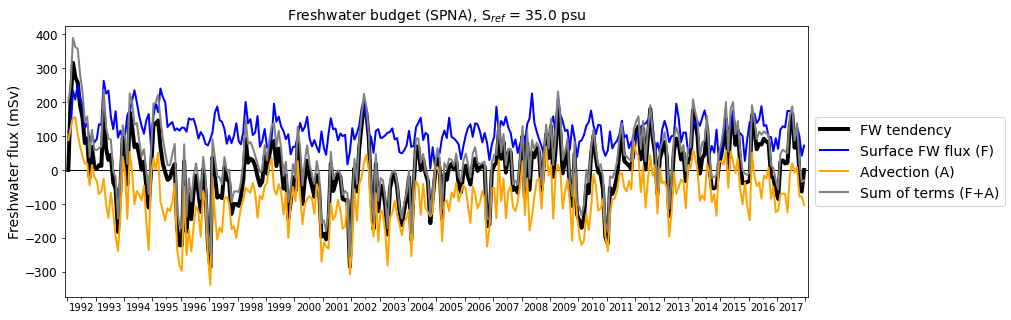

In [56]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set_title(r'Freshwater budget (SPNA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='tendFw')*1e3, lw=4, color='black',label='FW tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFw')*1e3, lw=2, color='blue',label='Surface FW flux (F)')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection (A)')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='totalFw')*1e3, lw=2, color='grey',label='Sum of terms (F+A)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 2, 1)])

ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

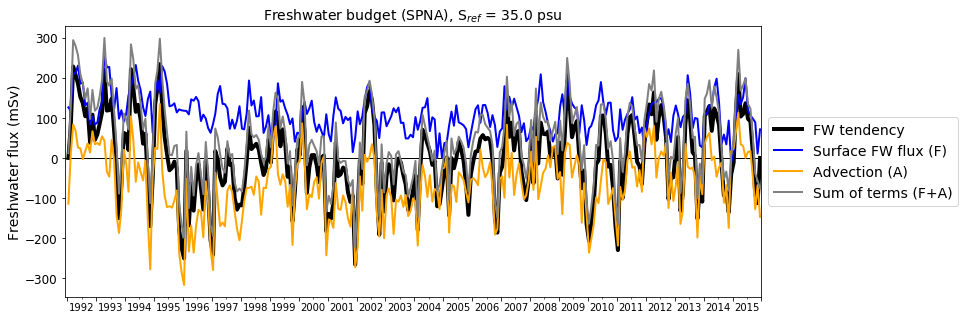

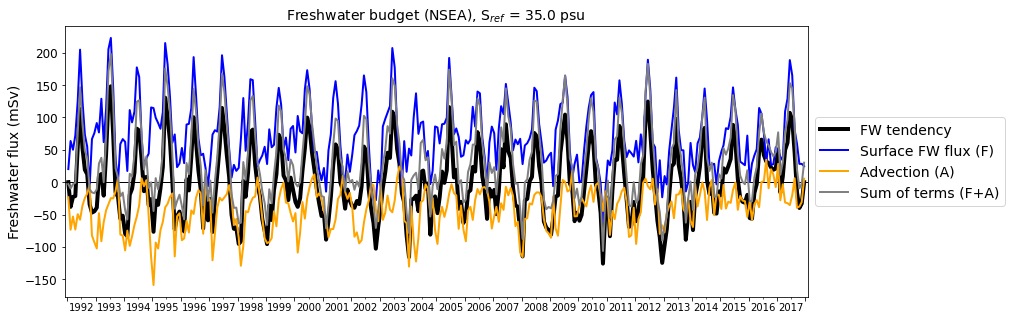

In [57]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set_title(r'Freshwater budget (NSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='tendFw')*1e3, lw=4, color='black',label='FW tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFw')*1e3, lw=2, color='blue',label='Surface FW flux (F)')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection (A)')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='totalFw')*1e3, lw=2, color='grey',label='Sum of terms (F+A)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 2, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

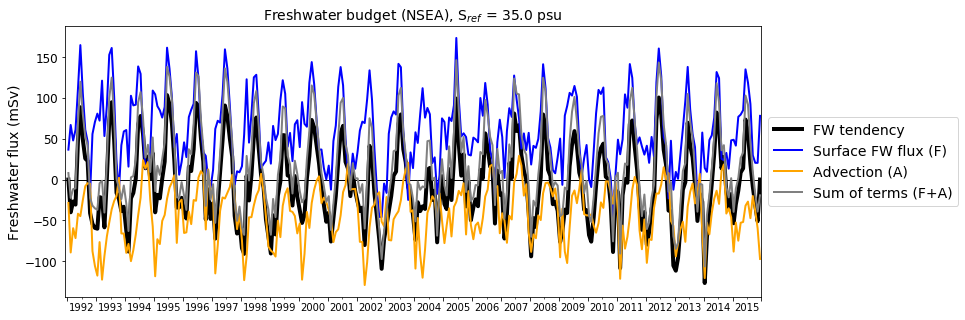

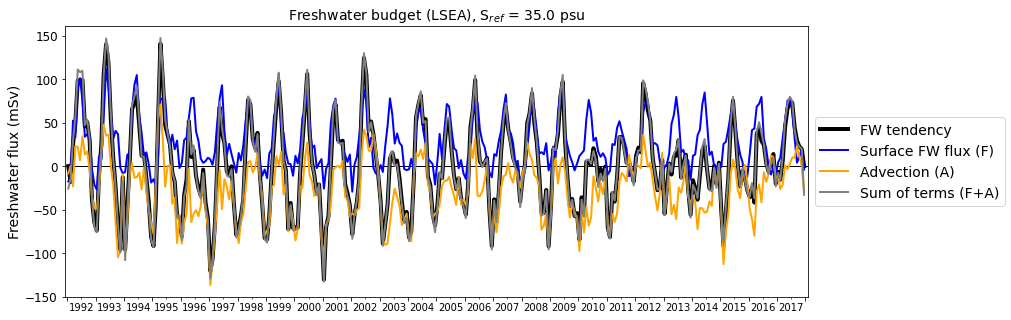

In [58]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set_title(r'Freshwater budget (LSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='tendFw')*1e3, lw=4, color='black',label='FW tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='forcFw')*1e3, lw=2, color='blue',label='Surface FW flux (F)')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection (A)')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='totalFw')*1e3, lw=2, color='grey',label='Sum of terms (F+A)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 2, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

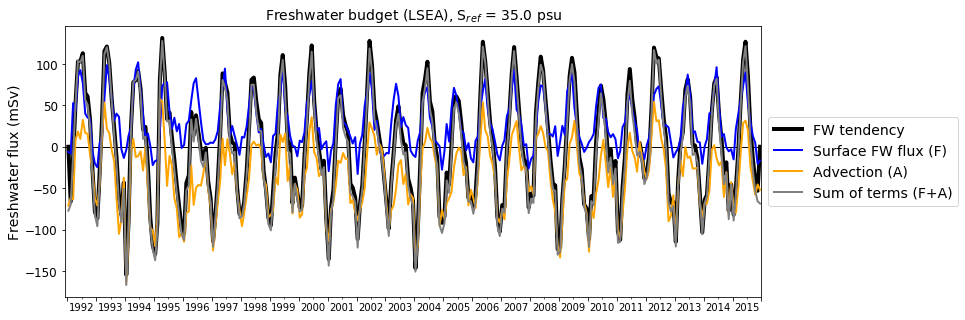

**Default section transports (Boundary fluxes)**

- 'Newfoundland Iberia': into *SPNA*
- 'English Channel': into *SPNA*
- 'Hudson Strait': out of *SPNA* (and out of *LSEA*)
- 'Davis Strait': out of *SPNA* (and out of *LSEA*)
- 'Denmark Strait': out of *SPNA* and into *NSEA*
- 'Iceland Faroe': out of *SPNA* and into *NSEA*
- 'Faroe Scotland': out of *SPNA* and into *NSEA*
- 'Scotland Norway': out of *NSEA*
- 'Fram Strait': out of *NSEA*
- 'Barents Sea': out of *NSEA*
- 'Labrador Greenland': into *LSEA*

In [59]:
ConvFw_spna_bnd = fw_trsp.sel(section='Newfoundland Iberia') + fw_trsp.sel(section='English Channel') \
                    - fw_trsp.sel(section='Hudson Strait') - fw_trsp.sel(section='Davis Strait') \
                    - fw_trsp.sel(section='Denmark Strait') - fw_trsp.sel(section='Iceland Faroe') \
                    - fw_trsp.sel(section='Faroe Scotland')

In [60]:
ConvFw_nsea_bnd = fw_trsp.sel(section='Denmark Strait') + fw_trsp.sel(section='Iceland Faroe') \
                    + fw_trsp.sel(section='Faroe Scotland') + fw_trsp.sel(section='Scotland Norway') \
                    - fw_trsp.sel(section='Fram Strait') - fw_trsp.sel(section='Barents Sea')

In [61]:
ConvFw_lsea_bnd = fw_trsp.sel(section='Labrador Greenland') - fw_trsp.sel(section='Hudson Strait') \
                    - fw_trsp.sel(section='Davis Strait')

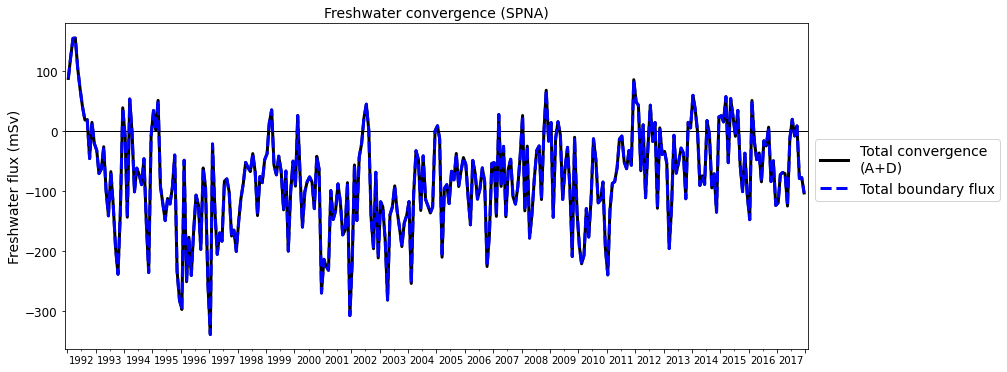

In [62]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='ConvFw')*1e3, lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvFw_spna_bnd.time, ConvFw_spna_bnd*1e3, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 2, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

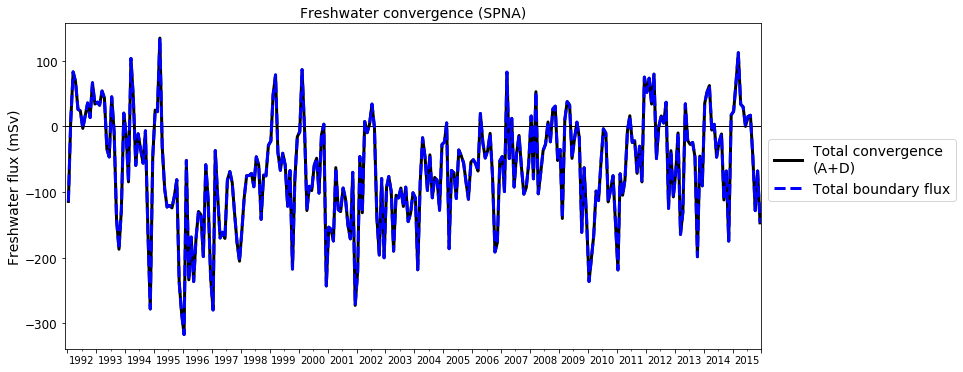

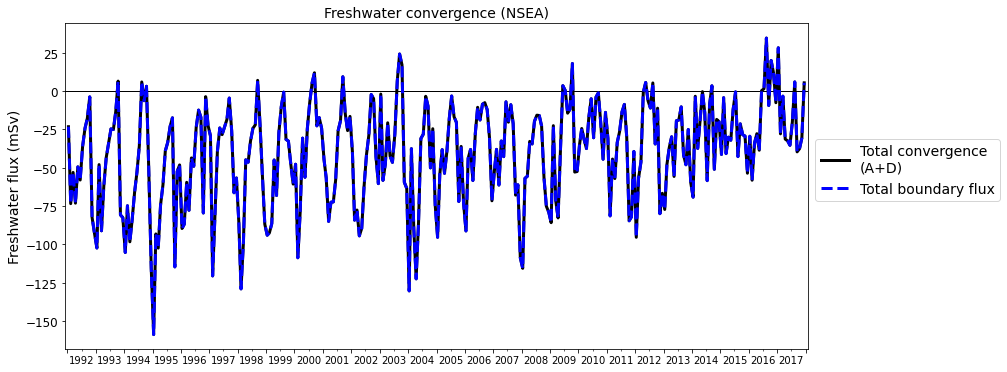

In [63]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title(r'Freshwater convergence (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='ConvFw')*1e3, lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvFw_nsea_bnd.time, ConvFw_nsea_bnd*1e3, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 2, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

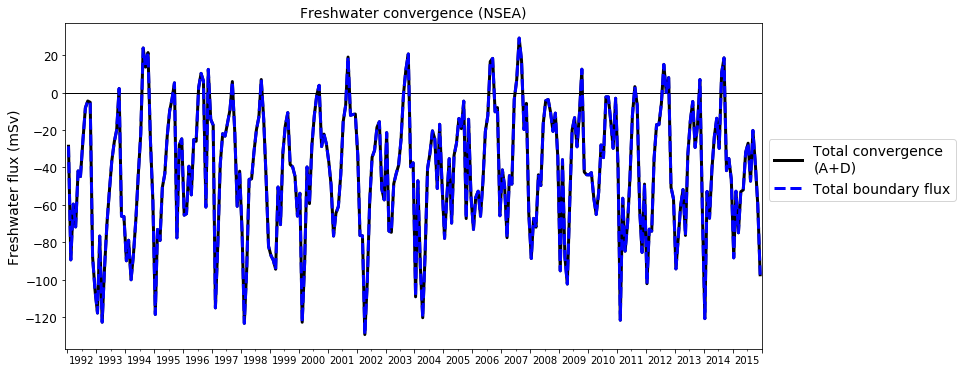

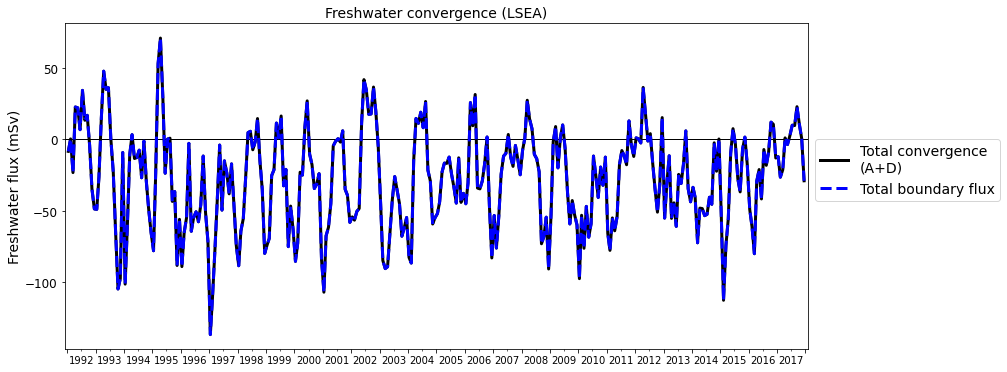

In [64]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title(r'Freshwater convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='ConvFw')*1e3, lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvFw_lsea_bnd.time, ConvFw_lsea_bnd*1e3, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 2, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

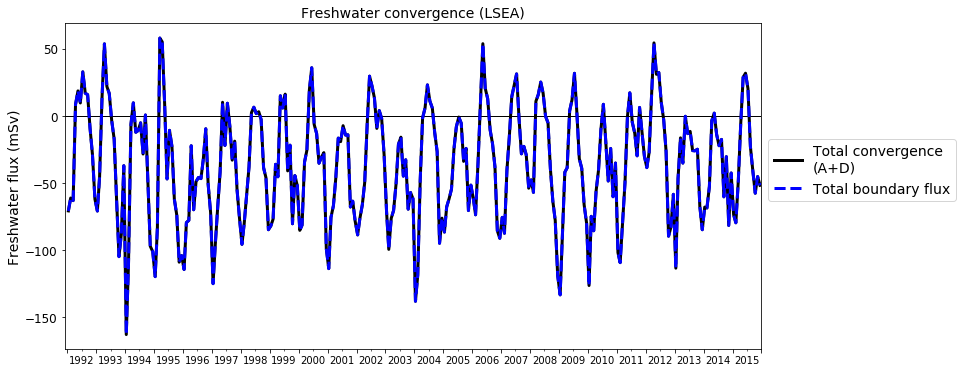

In [65]:
v1 = budg_fw.sel(region='spna',term='lfwc') - budg_fw.sel(region='spna',term='lfwc').mean('time')

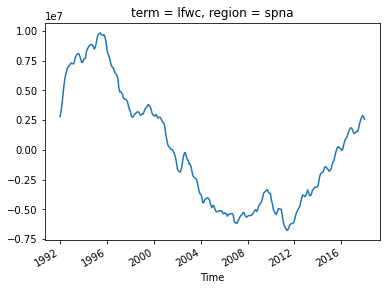

In [66]:
v1.plot()

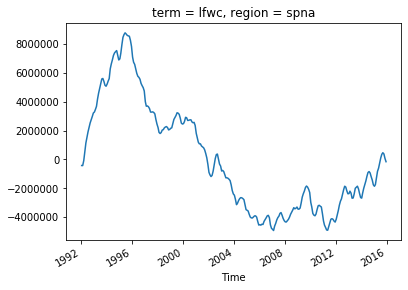

In [68]:
ls /mnt/efs/data/ecco/

budg_anom/                             ecco_section_transports_fw_eulerian.nc
ecco_budg_anom_fw.nc                   ecco_section_transports_heat.nc
ecco_budg_anom_heat.nc                 ecco_section_transports_slt.nc
ecco_budg_anom_sln.nc                  ecco_section_transports_slt_adv.nc
ecco_budg_fw.nc                        eccov4_spna_fw_flx.csv
ecco_budg_fw_Sref300.nc                eccov4_spna_heat_flx.csv
ecco_budg_fw_oceFW.nc                  eccov4r4/
ecco_budg_heat.nc                      eccov4r4_budg_heat.nc
ecco_budg_oceFW.nc                     eccov4r4_budg_vol.nc
ecco_budg_sln.nc                       eccov4r4_interp_salt.nc
ecco_budg_slt.nc                       eccov4r4_lfwc_nsea_monthly.nc
ecco_budg_vol.nc                       eccov4r4_lfwc_nsea_monthly_anom.nc
ecco_dz.nc                             eccov4r4_lfwc_nsea_pentad.nc
ecco_interp_area.nc                    eccov4r4_lfwc_spna_monthly.nc
ecco_lfwc_spna_monthly.nc              eccov4r4_lfwc_spna_monthly_an

In [69]:
lfwc_spna_ec_monthly = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_lfwc_spna_monthly.nc')
lfwc_nsea_ec_monthly = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_lfwc_nsea_monthly.nc')

In [71]:
v2 = lfwc_spna_ec_monthly.lfwc - lfwc_spna_ec_monthly.lfwc.mean('time')

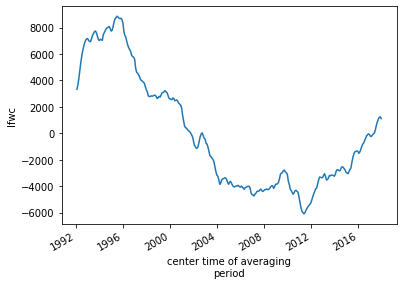

In [72]:
v2.plot()

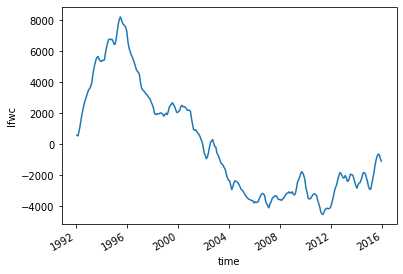

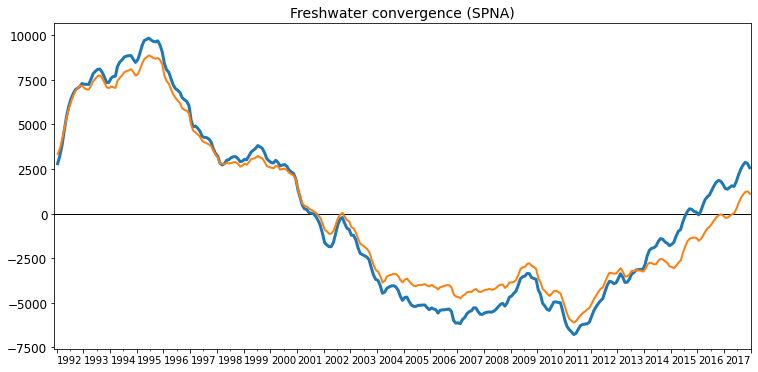

In [74]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(v1.time, v1*1e-3, lw=3)
ax.plot(v2.time, v2, lw=2)

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.yaxis.set_tick_params(labelsize=12)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

No handles with labels found to put in legend.


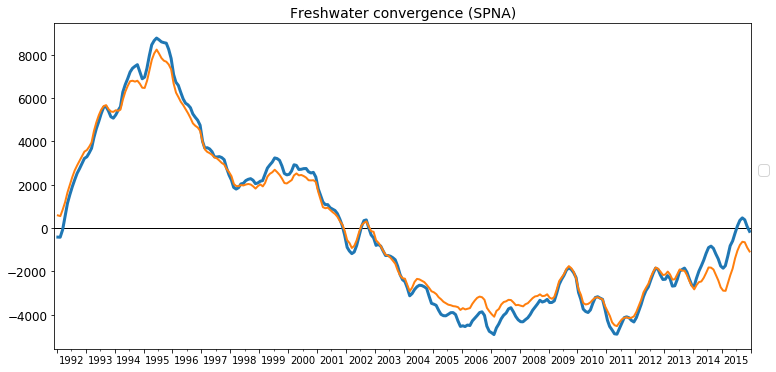

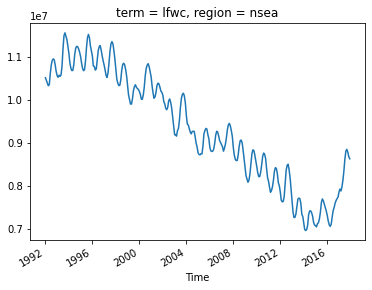

In [75]:
budg_fw.sel(region='nsea',term='lfwc').plot()

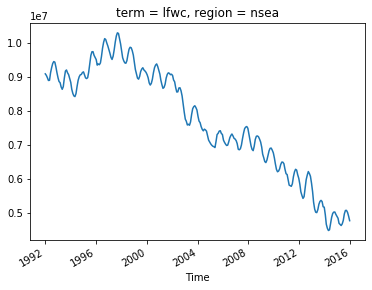

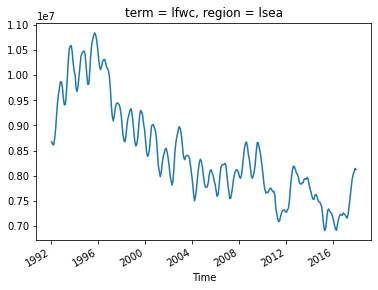

In [76]:
budg_fw.sel(region='lsea',term='lfwc').plot()

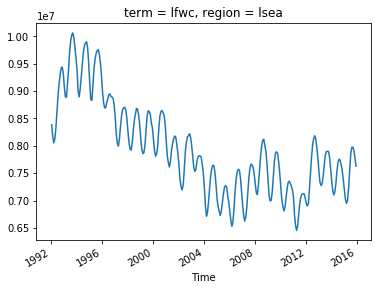